# Stopping track dQ/dx

The *stopping power* of a particle usually refers to the energy loss rate $dE/dx$ when it passes through matter. When charged particles travel through our LArTPC detector, they interact with the argon and lose energy.

## MIP and Bragg peak¶

Minimally ionizing particles (MIP) are charged particles which lose energy when passing through matter at a rate close to minimal. Particles such as muons often have energy losses close to the MIP level and are treated in practice as MIP. The only exception is when the muon comes to a stop and experiences a Bragg peak.

<figure>
<img src="bragg_peak.png" style="width:600px">
<figcaption align = "center"> Example of muon Bragg peak. The muon is travelling from bottom left to top right. The color scale represents energy deposition. Red means more energy deposited. The sudden increase in deposited (lost) energy towards the end of the muon trajectory is the Bragg peak. From MicroBooNE (arxiv: 1704.02927) </figcaption>
</figure>

## I. Motivation

We know that the energy loss rate of a MIP in argon is ~2 MeV/cm. Hence our goal is to carefully isolate the MIP-like sections of muons (i.e. leaving out the ends of the track), and compute the (reconstructed) energy loss along these trajectories $dQ/dx$. This can inform the detector calibration effort, for example, since we can compare the peak of the $dQ/dx$ histogram with the theoretical expected value (although there are many detector effects that make this not straightforward). We can also study the spatial uniformity of the detector by looking at MIP $dQ/dx$ values in different regions of the detector, etc. If we plot the dQ/dx change along the so-called "residual range" (i.e. distance to the end of the muon trajectory), we get a characteristic plot (due to the Bragg peak). In this tutorial we will focus on reproducing this plot.

<figure>
<img src="residual_range.png" style="width:600px">
<figcaption align = "center"> Example of what we expect for a track dQ/dx versus residual range 2d histogram. The sudden increase in deposited (lost) energy towards the end of the muon trajectory (= low residual range) is the Bragg peak. From MicroBooNE (arxiv: 2010.02390) </figcaption>
</figure>

## II. Setup

Again, we start by setting our working environment. Some necessary boilerplate code:

### a. Software and data directory

In [1]:
import os, sys

# SOFTWARE_DIR = '/sdf/data/neutrino/software/spine' # Change this path to your software install
SOFTWARE_DIR = '/sdf/group/neutrino/drielsma/dev/spine' # Change this path to your software install
DATA_DIR = '/sdf/data/neutrino/public_html/spine_workshop/' # Change this path if you are not on SDF (see main README)

# Set software directory
sys.path.insert(0, SOFTWARE_DIR)

### b. Numpy, Matplotlib, and Plotly for Visualization and data handling.

In [2]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re

# Visualization Tools
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns

### c. MLRECO specific imports for model loading and configuration setup

Let’s parse the analysis configuration file `anaconfig.cfg` to load the reconstruction output. This file uses the keyword `DATA_DIR` to symbolize the path to reconstructruted dataset. We need to replace it with the actual location defined previously.

In [3]:
# Load anatools config file
# Replace the source file with the correct path
DATA_PATH = DATA_DIR + 'reco/generic_small_spine.h5'
anaconfig = '../../template.cfg' 
anaconfig = yaml.safe_load(open(anaconfig, 'r').read().replace('DATA_PATH', DATA_PATH))

Let’s parse the analysis configuration file `anaconfig.cfg` to load the reconstruction output. This file uses the keyword `DATA_DIR` to symbolize the path to reconstructruted dataset. We need to replace it with the actual location defined previously.

In [4]:
# Initialize Anatools manager
from spine.driver import Driver

driver = Driver(anaconfig)

Welcome to JupyROOT 6.22/08

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1721767406}
io:
  reader: {name: hdf5, file_keys: /sdf/data/neutrino/public_html/spine_workshop/reco/generic_small_spine.h5}
build: {mode: both, units: cm, fragments: false, particles: true, interactions: true}

Will load 1 file(s):
  - /sdf/data/neutrino/public_html/spine_workshop/reco/generic_small_spine.h5

Total number of entries in the file(s): 6

Total number of entries selected: 6



We are now all set to load **one iteration** of the reconstruction output as follows:

### d. Load data/reconstruction output

We are now all set to load **one iteration** of the reconstruction output as follows:

In [5]:
ENTRY_NUM = 3
data = driver.process(entry=ENTRY_NUM)

The input data and label information are loaded onto the `data` variable, while the outputs from the chain are stored inside `result`. We will use the output of this single iteration to demonstrate a simple Michel electron selection, before running with higher statistics (ie. performing many more iterations).

Now we load the true and reconstucted ``Particle`` objects:

In [6]:
reco_particles = data['reco_particles']
truth_particles = data['truth_particles']

## III. Visualize true and predicted particles

Let’s first import plotting functions from `lartpc_mlreco3d` for easier visualization:

In [7]:
from spine.vis.out import Drawer
from spine.vis.point import scatter_points
from spine.vis.layout import PLOTLY_COLORS_WGRAY, layout3d

The evaluator will handle ghost masking internally, so all you have to do is retrieve the predicted and true semantic segmentation labels for visualization and analysis:

By default, the label for tracks and michel electrons are 1 and 2, respectively.

In [8]:
from spine.utils.enums import ShapeEnum

list(ShapeEnum)

[<ShapeEnum.SHOWER: 0>,
 <ShapeEnum.TRACK: 1>,
 <ShapeEnum.MICHEL: 2>,
 <ShapeEnum.DELTA: 3>,
 <ShapeEnum.LOWE: 4>,
 <ShapeEnum.GHOST: 5>]

In [9]:
drawer = Drawer(data)

fig = drawer.get('particles', attr='shape')

fig.show()

The predicted particles, each color-coded according to its semantic type, will be displayed in left; the true particles on right.

## I. Select stopping muons
We will select track-like predicted particles that are close to a Michel predicted particle.
For the stopping muon residual range study purpose, purity is more important than efficiency.
Hence we only select stopping muons that decay into a Michel electron.

In [10]:
from scipy.spatial.distance import cdist

def get_stopping_muons(particles, Michel_threshold=10):
    selected_muons = []
    closest_points = []

    # Loop over predicted particles
    for p in particles:
        if p.shape != ShapeEnum.TRACK: continue
        coords = p.points

        # Check for presence of Michel electron
        attached_to_Michel = False
        closest_point = None
        for p2 in particles:
            if p2.shape != ShapeEnum.MICHEL: continue
            d =  cdist(p.points, p2.points)
            if d.min() >= Michel_threshold: continue
            attached_to_Michel = True
            closest_point = d.min(axis=1).argmin()

        if not attached_to_Michel: continue

        selected_muons.append(p)
        closest_points.append(closest_point)

    return selected_muons, closest_points

In [11]:
selected_muons, closest_points = get_stopping_muons(reco_particles)
for part in selected_muons:
    print(part)

RecoParticle(ID: 6   | PID: Muon     | Primary: 1  | Size: 719   | Match: 10 )


And just as a sanity check, let's run the same function on the true particles to ensure it selects what we expect:

In [12]:
for part in get_stopping_muons(truth_particles)[0]:
    print(part)

TruthParticle(ID: 10  | PID: Muon     | Primary: 1  | Size: 721   | Match: 6  )


## II. Muon direction with PCA
Once we have a suitable muon selected, the next step is to bin it. To make the binning easier, we will find the approximate direction of the muon using principal component analysis (PCA) then project all muon voxels along this axis.

In [13]:
from sklearn.decomposition import PCA

def get_PCA(particles):
    pca = PCA(n_components=1)
    pca_coordinates = []
    pca_directions = []
    for p in particles:
        coords = p.points
        # PCA to get a rough direction
        coords_pca = pca.fit_transform(p.points)[:]
        pca_coordinates.append(coords_pca.flatten())
        pca_directions.append(pca.components_[0])

    return pca_coordinates, pca_directions

Time to run our function on the muon we just selected:

In [14]:
pca_coordinates, pca_directions = get_PCA(selected_muons)

It is always a good idea to visualize the output of each intermediate stage to make sure the output is not garbage for the next step. The muon voxels are in blue, the computed PCA direction is in orange.

In [15]:
trace = []

for idx, (coords, direction) in enumerate(zip(pca_coordinates, pca_directions)):
    trace += scatter_points(selected_muons[idx].points,
                            markersize=1,
                            color='blue')

    # Artificially create a point cloud for the PCA direction visualization
    pca_points = selected_muons[idx].points[coords.argmin()][None, :] + direction[None, :] * (coords[:, None]-coords.min())
    trace += scatter_points(pca_points,
                            markersize=1,
                            color='orange')

fig = go.Figure(data=trace, layout=layout3d(meta=data['meta'], detector_coords=True))
iplot(fig)

The orange direction seems to match *roughly* the muon direction, so we can move on to the next step.

## III Local dQ/dx

Using the rough muon direction, we will define segments by binning the projection of all voxels onto this axis.

In [16]:
def get_dQdx(particles, closest_points, pca_coordinates,
             bin_size=5, # cm
             return_pca=False):

    df = {
        "dQ": [],
        "dx": [],
        "residual_range": []
    }

    pca = PCA(n_components=1)

    list_coords, list_pca, list_directions = [], [], []
    for p, closest_point, coords_pca in zip(particles, closest_points, pca_coordinates):
        coords = p.points

        # Make sure where the end vs start is
        # if end == 0 we have the right bin ordering, otherwise might need to flip when we record the residual range
        distances_endpoints = [((coords[coords_pca.argmin(), :] - coords[closest_point, :])**2).sum(), ((coords[coords_pca.argmax(), :] - coords[closest_point, :])**2).sum()]
        end = np.argmin(distances_endpoints)

        # Split into segments and compute local dQ/dx
        if not end: # no need to flip
            bins = np.arange(coords_pca.min(), coords_pca.max(), bin_size)
            bin_inds = np.digitize(coords_pca, bins)
        else: # must flip
            bins = np.arange(-coords_pca.max(), -coords_pca.min(), bin_size)
            bin_inds = np.digitize(-coords_pca, bins)

        for i in np.unique(bin_inds):
            mask = bin_inds == i
            if np.count_nonzero(mask) < 2: continue

            # Repeat PCA locally for better measurement of dx
            pca_axis = pca.fit_transform(p.points[mask])
            list_coords.append(p.points[mask])
            list_pca.append(pca_axis.flatten())
            list_directions.append(pca.components_[0])

            dx = pca_axis[:, 0].max() - pca_axis[:, 0].min()
            dQ = p.depositions[mask].sum()
            residual_range = ((i - 0.5) * bin_size)

            df["dx"].append(dx)
            df["dQ"].append(dQ)
            df["residual_range"].append(residual_range)

    df = pd.DataFrame(df)

    if return_pca:
        return list_coords, list_pca, list_directions

    return df     

For each segment, we compute
* dQ (sum of reconstructed charge of all voxels in the segment)
* dx (for better precision we recompute a local PCA direction on the segment voxels exclusively)
* residual range (distance from the muon end, well-defined using the Michel contact point)

In [17]:
get_dQdx(selected_muons, closest_points, pca_coordinates)

dQ        dx  residual_range
0   29.278297  4.815865             2.5
1   18.699163  4.871116             7.5
2   13.737882  4.624879            12.5
3   12.611551  4.874074            17.5
4   12.292276  4.845059            22.5
5   12.222911  4.917746            27.5
6    9.927843  4.576751            32.5
7   11.118335  4.919302            37.5
8   12.258119  4.588553            42.5
9   11.168406  4.891025            47.5
10   9.393162  4.588718            52.5
11  10.530970  4.593248            57.5
12  14.065078  4.888528            62.5
13  10.498427  4.597699            67.5
14   9.960473  4.917198            72.5
15   8.979929  4.595747            77.5
16   9.126225  4.548156            82.5
17  10.294911  4.840965            87.5
18  11.182809  4.589891            92.5
19  10.625892  4.892176            97.5
20   9.280003  4.548052           102.5
21   8.910358  4.627433           107.5
22  10.015209  4.920106           112.5
23   9.936313  4.661300           117.5
24  10.640668  4.594189           122.5
25  11.076764  4.872504           127.5
26   9.265310  4.548779           132.5
27   9.784075  4.868424           137.5
28   9.034169  4.548179           142.5
29   9.511644  4.845399           147.5
30  10.856956  4.588481           152.5
31   9.674087  4.867632           157.5
32   8.851459  4.590640           162.5
33   9.788578  4.845227           167.5
34   9.936487  4.539036           172.5
35   3.196862  1.555021           177.5

Once again, let's take the time to visualize the binning and make sure the segments make sense. The black voxels belong to the local PCA directions, the colored voxels belong to different segments (color = segment id).

In [18]:
import matplotlib.pyplot as plt
trace = []

list_coords, list_pca, list_directions = get_dQdx(selected_muons, closest_points, pca_coordinates, return_pca=True)
cmap = plt.cm.get_cmap('Set1')
n = len(list_coords)
for idx, (coords, pca_axis, direction) in enumerate(zip(list_coords, list_pca, list_directions)):
    trace += scatter_points(coords,
                            markersize=2,
                            color='rgb%s' % str(cmap(idx/n)[:-1]))
    #print(direction[None, :] * coords[:, None])
    #print(cmap(idx/n))
    pca_points = coords[pca_axis.argmin()][None, :] + direction[None, :] * (pca_axis[:, None]-pca_axis.min())
    trace += scatter_points(pca_points,
                           markersize=2,
                           color='black')


fig = go.Figure(data=trace,layout=layout3d(meta=data['meta'], detector_coords=True))
iplot(fig)

## IV. Repeat with high statistics
We have computed everything we want, we just need to repeat this with higher statistics.

In [19]:
muons = pd.DataFrame({
        "index": [],
        "dQ": [],
        "dx": [],
        "residual_range": []
    })

from tqdm import tqdm
for iteration in tqdm(range(100)):
    if iteration >= len(driver):
        break
    data = driver.process(entry=iteration)
    index = data['index']
    
    reco_particles = data['reco_particles']
    # truth_particles = data['truth_particles']

    selected_muons, closest_points = get_stopping_muons(reco_particles)
    pca_coordinates, pca_directions = get_PCA(selected_muons)
    df = get_dQdx(selected_muons, closest_points, pca_coordinates)
    df['index'] = index
    muons = pd.concat([muons, df])

  6%|▌         | 6/100 [00:00<00:02, 37.22it/s]


In [20]:
muons

index         dQ        dx  residual_range
0     0.0  27.349108  4.956691             2.5
1     0.0  15.128755  4.656952             7.5
2     0.0  14.930378  4.837129            12.5
3     0.0  11.480001  4.586117            17.5
4     0.0  11.171758  4.596209            22.5
..    ...        ...       ...             ...
31    3.0   9.674087  4.867632           157.5
32    3.0   8.851459  4.590640           162.5
33    3.0   9.788578  4.845227           167.5
34    3.0   9.936487  4.539036           172.5
35    3.0   3.196862  1.555021           177.5

[64 rows x 4 columns]

## Plot dQ/dx vs residual range

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

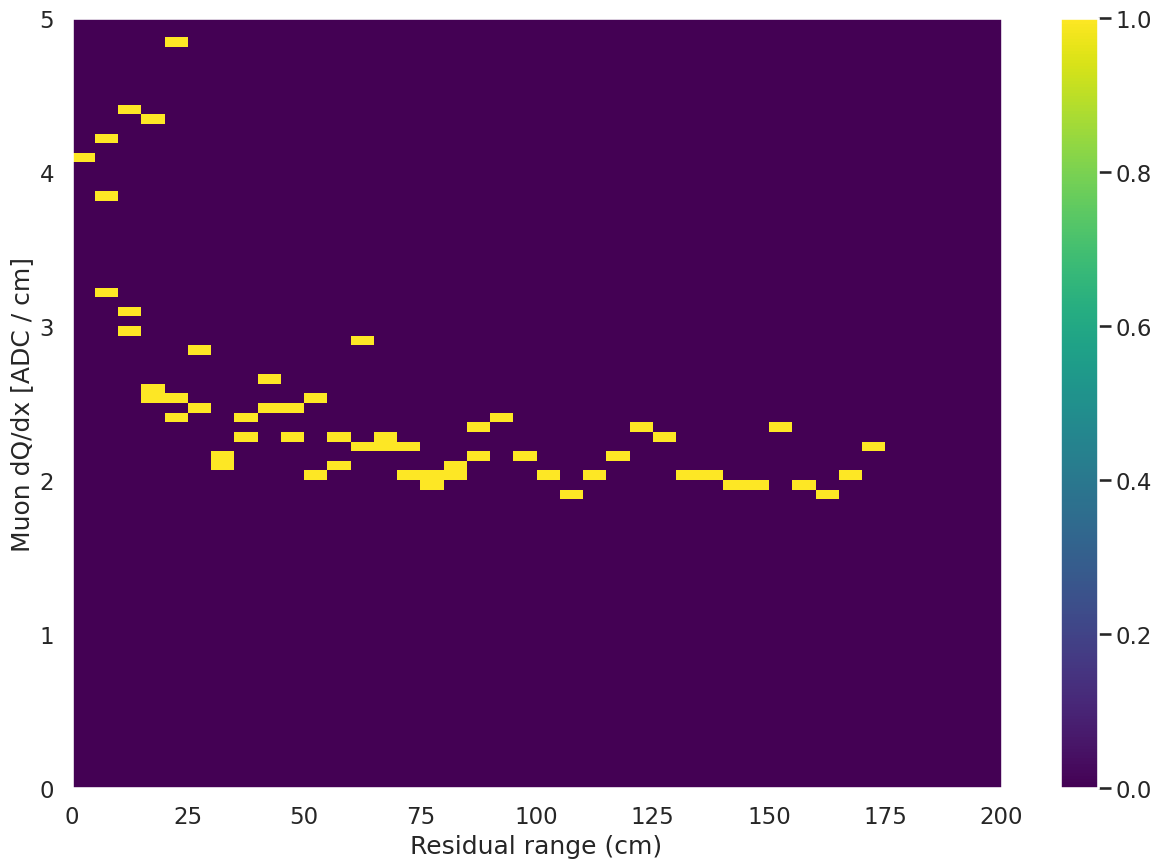

In [22]:
clean = (muons["dx"] > 3.5) & (muons["dx"] < 50) #& (cells['pca_length'] > 150)
#clean = np.ones(shape=muons["residual_range"].shape, dtype=np.bool)
plt.hist2d(muons["residual_range"][clean], muons["dQ"][clean]/(muons["dx"][clean]),
          # range=[[0, 200], [0, 2000]], bins=[40, 80],
          range=[[0, 200], [0, 5]], bins=[40, 80],
          cmap="viridis")
plt.colorbar()
plt.xlabel("Residual range (cm)")
plt.ylabel("Muon dQ/dx [ADC / cm]")
plt.show()

***

# $dE/dx$ visualization for muons, pions, and protons
In practice, we would like to visualize the $dE/dx$ vs. residual lengths for certain types of particles. In this case we are taking muons, pions, and protons as examples. 2D histograms will be helpful for us to observe the $dE/dx$ distribution in each case.

It's simply two major steps:
- Step 1: Extract values and save them into CSVs to be used.
- Step 2: Make 2D histograms based particle types.

## Step 1: Extract $dE/dx$ values from dataset and save them in CSVs
### 1.1 - Set up data paths and output directory
The first step is to specify what sample file(s) we would like to iterate over. In this case we are using `MPVMPR` samples.

In [23]:
import glob
from tqdm import tqdm
import os
import gc

# Create output directory
output_dir = '/sdf/home/c/castalyf/spine_workshop_2024/reconstruction/stopping_track_dqdx' # change the path to your default location
os.makedirs(output_dir, exist_ok=True)

# data_paths = glob.glob('/sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/output_spine/*.h5') # To run all .h5 files, uncomment this line
data_paths = ['/sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/output_spine/larcv_test_2500_spine.h5'] # To run specific .h5 file(s), change to your data path

### 1.2 - Define the fraction of visible energy
We have to make sure particles are ranged out, i.e. that they do not have daughter particles, particularly for protons/pions. They both can re-interact with other argon nuclei, in which case the $dQ/dx$ will not follow the profile of particle stopping through ionization only. The fraction of visible energy is defined by

$$
f_{vis} = \frac{\text{Energy deposited in the detector}}{\text{True intial energy}}
$$

The ratio's threshold will be set to $f_{vis} > 0.95$ in the next step (Step 1.3).

In [24]:
# Function to calculate f_vis
def calc_f_vis(truth_particle):
    ke = truth_particle.ke
    vis_e = truth_particle.depositions_g4_sum
    return vis_e / ke

### 1.3 - Extract values by iterating over data (only need to run ONCE when the new samples are loaded)
This step might take longer depending on the `data_paths` we defined earlier (can be 1 hr or longer), however, we just need to run **once** for the new dataset i.e. when you are going to extract the new $dE/dx$ values. In other words, be sure to run this cell **only if** you have changed the files in `data_paths`. If the paramters have been saved into CSV (Step 1.4) already, **you may skip this step and move on to Step 2.1 for loading saved values and making plots**. That way we can save a lot of time.

Note here we are using `get_track_segment_dedxs` function, which has included PCA steps for locating directions in the background. We also filtered the particles e.g. ensuring each of them `is_primary` and `is_contained`, etc.

The general code structure of this step looks like the following:

- Iterate over testing samples.
     - Iterate over all entries for each sample.
        - Iterate over particles, using `truth_particles`’ PIDs.
            - Select particles that are **contained** (start/stop in the detector).
            - Select particles that are **primaries** (directly come from interaction vertex).
                - Ranged out with $f_{vis} > 0.95$ (i.e. filter to the ones that they don't have daughters)
                    - Iterate over PIDs (muons, pions, and protons)
                        - Get all $dE/dx$ values, residual lengths
                        - Save them into three separate CSVs (Step 1.4).

In [25]:
from spine.utils.tracking import get_track_segment_dedxs

# Initialize dictionaries outside the loop
pids = [2, 3, 4]
all_dedxs_dict = {pid: [] for pid in pids}
all_rrs_dict = {pid: [] for pid in pids}
all_data_dict = {pid: [] for pid in pids}
all_entries_dict = {pid: [] for pid in pids}
all_id_dict = {pid: [] for pid in pids}

# Iterate over testing samples.
for DATA_PATH in data_paths:
    print(f'Processing: {DATA_PATH}')
    
    # Replace DATA_PATH in the configuration
    anaconfig = '../../template.cfg' 
    anaconfig = yaml.safe_load(open(anaconfig, 'r').read().replace('DATA_PATH', DATA_PATH))
    
    # Initialize the Driver with the loaded configuration
    driver = Driver(anaconfig)
    
    for entry in tqdm(range(len(driver))):
        data = driver.process(entry)
        
        reco_particles = data['reco_particles']
        truth_particles = data['truth_particles']

        for particle in reco_particles:
            if len(particle.match_ids) == 1: 
                match_id = particle.match_ids[0]
                truth_particle = truth_particles[match_id]
                
                if truth_particle.is_contained == 0 or not truth_particle.is_primary: continue
                
                if calc_f_vis(truth_particle) > 0.95: # Fraction of visible energy's threshold.
                    pid = truth_particle.pid

                    if pid in pids:
                        depositions = particle.depositions
                        values = 0.002 * depositions # The ADC-MeV converesion factor (to be calibrated). 
                        coordinates = particle.points
                        end_point = particle.end_point

                        # Extract dE/dx values.
                        track_info = get_track_segment_dedxs(coordinates, values, end_point, segment_length=5)
                        all_dedxs_dict[pid].extend(track_info[0])
                        all_rrs_dict[pid].extend(track_info[2])

                        data_pad = np.full(len(track_info[0]), DATA_PATH)
                        entry_pad = np.full(len(track_info[0]), entry)
                        id_pad = np.full(len(track_info[0]), truth_particle.id)

                        all_data_dict[pid].extend(data_pad)
                        all_entries_dict[pid].extend(entry_pad)
                        all_id_dict[pid].extend(id_pad)



Processing: /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/output_spine/larcv_test_2500_spine.h5

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1721767410}
io:
  reader: {name: hdf5, file_keys: /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/output_spine/larcv_test_2500_spine.h5}
build: {mode: both, units: cm, fragments: false, particles: true, interactions: true}

Will load 1 file(s):
  - /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/output_spine/larcv_test_2500_spine.h5

Total number of entries in the file(s): 3300

Total number of e

100%|██████████| 3300/3300 [06:15<00:00,  8.78it/s]


### 1.4 - Save the $dE/dx$ and $rrs$ into CSV files

In [26]:
# Save the accumulated data to CSV files
for pid in pids:
    df = pd.DataFrame({
        'data': all_data_dict[pid],
        'entry': all_entries_dict[pid], 
        'true id': all_id_dict[pid], 
        'dedxs': all_dedxs_dict[pid], 
        'rrs': all_rrs_dict[pid]
    })
    df.to_csv(f'mpvmpr_dedxs_rrs_pid_{pid}.csv', index=False)

for pid in pids:
    print(f'PID {pid}: Saved {len(all_dedxs_dict[pid])} dedxs and {len(all_rrs_dict[pid])} rrs values.')


PID 2: Saved 758 dedxs and 758 rrs values.
PID 3: Saved 226 dedxs and 226 rrs values.
PID 4: Saved 9841 dedxs and 9841 rrs values.


## Step 2: Make 2D histograms for muons, pions, and protons
If you have done Step 1 previously, you may skip those steps and directly move on to Step 2, since the values have been iterated and saved into the CSVs, and we can directly load these values from them to make necessary plots.

### 2.1 - Load data from the CSVs

In [27]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define particle PIDs
pids = [2, 3, 4]

# Initialize dictionaries to store data
dedxs_data = {}
rrs_data = {}

# Load data for each PID
for pid in pids:
    file_path = os.path.join(output_dir, f'mpvmpr_dedxs_rrs_pid_{pid}.csv')
    df = pd.read_csv(file_path)
    dedxs = df['dedxs']
    rrs = df['rrs']
    dedxs_data[pid] = dedxs
    rrs_data[pid] = rrs


So far we have the three CSV files with $dE/dx$, $rrs$ values saved therein, let's see what they look like:

In [28]:
for pid in pids:
    print(f'Data for PID {pid}:')
    file_path = os.path.join(output_dir, f'mpvmpr_dedxs_rrs_pid_{pid}.csv')
    df = pd.read_csv(file_path)
    display(df)
    print('\n')

Data for PID 2:


data  entry  true id  \
0    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      7        1   
1    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      7        1   
2    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      7        1   
3    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...     40        4   
4    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...     70        2   
..                                                 ...    ...      ...   
753  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3219        0   
754  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3219        0   
755  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3243        2   
756  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3243        2   
757  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3243        2   

        dedxs        rrs  
0    4.666400   2.500000  
1    3.229200   7.500000  
2   -1.000000  10.370186  
3    3.996700   2.362199  
4    4.629185   1.484927  
..        ...        ...  
753  4.543601  52.500000  
754 -1.000000  55.424187  
755  4.810801   2.500000  
756  2.898800   7.500000  
757  2.954758  11.587608  

[758 rows x 5 columns]



Data for PID 3:


data  entry  true id  \
0    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...     52        6   
1    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...     52        6   
2    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...    144        5   
3    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...    187        5   
4    /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...    187        5   
..                                                 ...    ...      ...   
221  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3177        6   
222  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3272        4   
223  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3272        4   
224  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3272        4   
225  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3296        6   

        dedxs        rrs  
0    4.555200   2.500000  
1    2.550673   6.499212  
2   -1.000000   0.653833  
3    5.417200   2.500000  
4    3.002800   7.500000  
..        ...        ...  
221 -1.000000  20.190260  
222  3.884400   2.500000  
223 -1.000000   7.500000  
224 -1.000000  10.782336  
225 -1.000000   0.000000  

[226 rows x 5 columns]



Data for PID 4:


data  entry  true id  \
0     /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      2        3   
1     /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      2        3   
2     /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      2        3   
3     /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      2        3   
4     /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...      2        3   
...                                                 ...    ...      ...   
9836  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3295        3   
9837  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3295        3   
9838  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3295        3   
9839  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3295        3   
9840  /sdf/data/neutrino/sbnd/spine/prod/mpvmpr_v01/...   3297        7   

         dedxs        rrs  
0     5.990401   2.500000  
1     2.896400   7.500000  
2     3.530000  12.500000  
3     2.862000  17.500000  
4     3.978524  21.845911  
...        ...        ...  
9836  8.155199   2.500000  
9837  5.929201   7.500000  
9838  5.448400  12.500000  
9839  4.477963  16.180447  
9840  8.894865   1.349992  

[9841 rows x 5 columns]

### 2.2 - Filter data and define particle types for plotting
It would now be straightforward to make 2D histograms based on those extracted values. We get rid of the invalid segments such as `dedxs = -1` - those are from segments that do not have space points or segments with not enough space points.

We also get types of particles prepared for plotting.

In [29]:
# Initialize dictionaries to store filtered data
filtered_dedxs_data = {}
filtered_rrs_data = {}

# Filter out invalid data
for pid in pids:
    dedxs = dedxs_data[pid]
    rrs = rrs_data[pid]
    filtered_dedxs = dedxs[dedxs != -1]
    filtered_rrs = rrs[dedxs != -1]
    filtered_dedxs_data[pid] = filtered_dedxs
    filtered_rrs_data[pid] = filtered_rrs

# Define particle types
particle_types = {
    0: 'Photon',
    1: 'Electron',
    2: 'Muon',
    3: 'Pion',
    4: 'Proton'
}

def get_particle_type(pid):
    if pid in particle_types:
        return particle_types[pid]

### 2.3 - Calculate predicted $dE/dx$ curves
To compare with the predicted results, it will be helpful to plot the predicted Bethe-Bloch curves. The theoretical curves can be introduced by the functions under `spine.utils.energy_loss`.

In [30]:
from spine.utils.energy_loss import csda_ke_lar, bethe_bloch_lar
from spine.utils.globals import *


# Define points for plotting
points = np.linspace(0.05, 200, 1000)

# Calculate expected dE/dx values
exp_dedxs = np.empty((3, len(points)), dtype=np.float32)

for j in range(2, 5):
    mass = PID_MASSES[j]
    for i, p in enumerate(points):
        T = csda_ke_lar(p, mass)
        dedx = -bethe_bloch_lar(T, mass)
        exp_dedxs[j-2][i] = dedx


### 2.4 - Make 2D histograms for muons, pions, and protons and compare with the predicted curves
Armed with everything we have had, we can make 2D histograms for these three particles now.

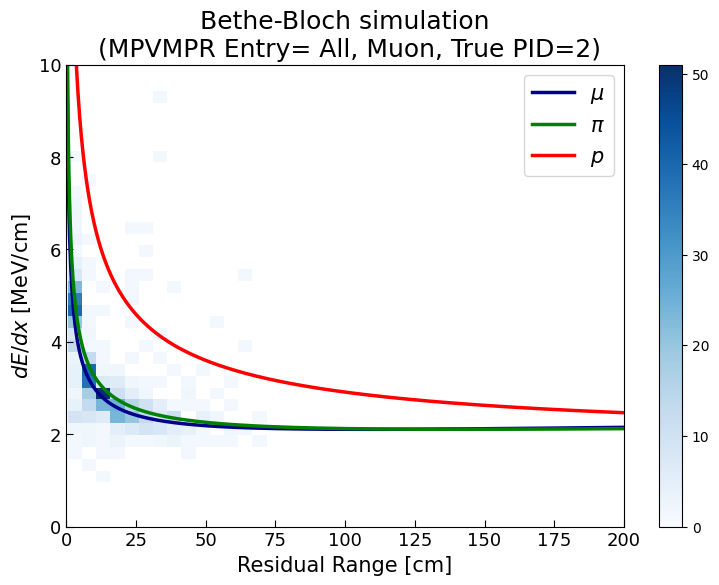

<Figure size 640x480 with 0 Axes>

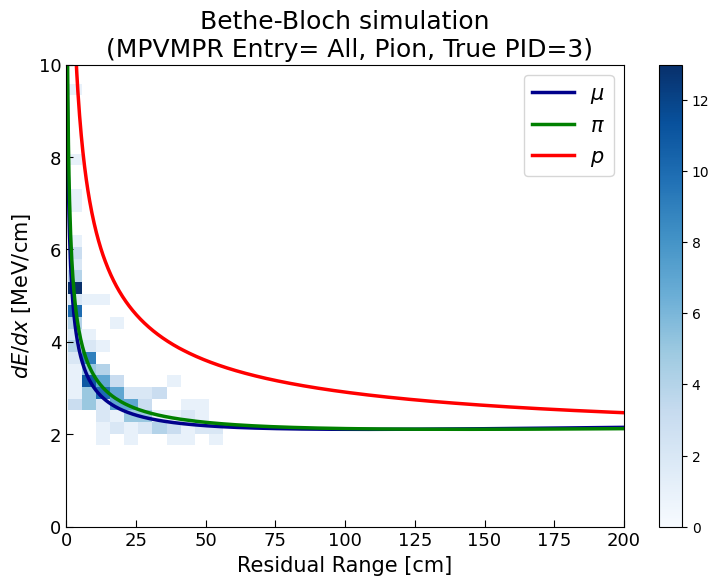

<Figure size 640x480 with 0 Axes>

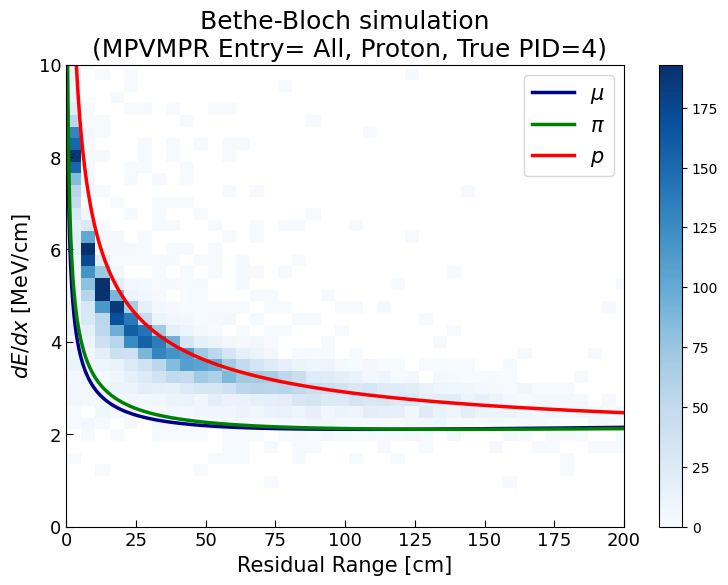

<Figure size 640x480 with 0 Axes>

In [31]:
# Set plotting style
plt.style.use('default')

# Plot data for each PID
for pid in pids:
    all_dedxs = filtered_dedxs_data[pid]
    all_rrs = filtered_rrs_data[pid]

    plt.figure(figsize=(9, 6))
    
    # Make plots and set appropriate segment lengths.
    sns.histplot(x=all_rrs, y=all_dedxs, bins=[int((max(all_rrs) - min(all_rrs)) / 5), 
                                                int((max(all_dedxs) - min(all_dedxs)) / 0.25)],
                                                cmap='Blues', cbar=True)
    
    
    # Formatting plot styles.
    plt.grid(False)
    plt.tick_params(axis='both', which='both', direction='in', length=5, color='black', labelsize=13)

    plt.plot(points, exp_dedxs[0], label=r'$\mu$', color='darkblue', linewidth=2.5)
    plt.plot(points, exp_dedxs[1], label=r'$\pi$', color='green', linewidth=2.5)
    plt.plot(points, exp_dedxs[2], label=r'$p$', color='red', linewidth=2.5)

    plt.xlabel('Residual Range [cm]', fontsize=15)
    plt.ylabel('$dE/dx$ [MeV/cm]', fontsize=15)
    plt.xlim(0, 200)
    plt.ylim(0, 10)

    particle_type = get_particle_type(pid)
    plt.title(f'Bethe-Bloch simulation\n (MPVMPR Entry= All, {particle_type}, True PID={pid})', fontsize=18)
    plt.legend(fontsize=15)
    title = f'Bethe_Bloch_2Dhist_MPVMPR_PID={pid}'
    
    plt.show()

    
    # Save the plots.
    plt.savefig(os.path.join(output_dir, title.lower().replace(" ", "_") + '.png'))



We have beautiful plots now!

Note that, as mentioned in Step 1.3, the discernible shift in the proton's plot comes from the ADC-MeV conversion factor, which will be calibrated. We can generally see that the $dE/dx$ distribution of the three reconstructed particles matches the predicted curves. It is even distinguishable between the muon's and the pion's plots if we look carefully at both.

### 2.5 - Another version of the plots
For those who prefer to dark background.

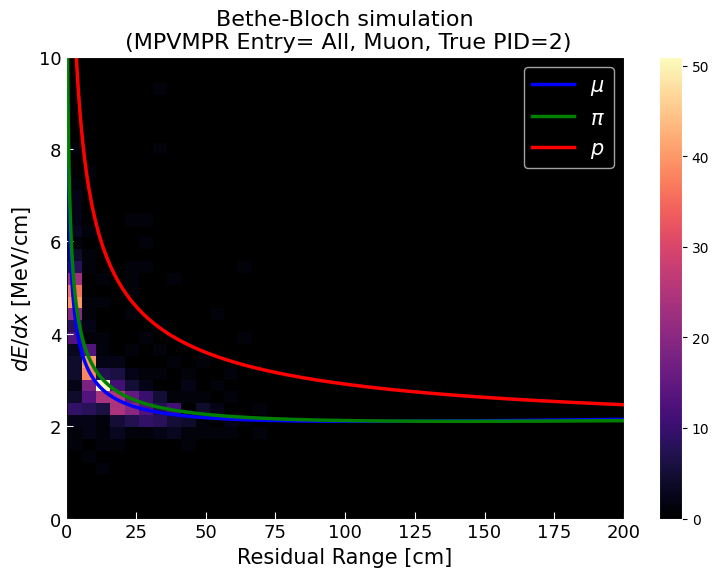

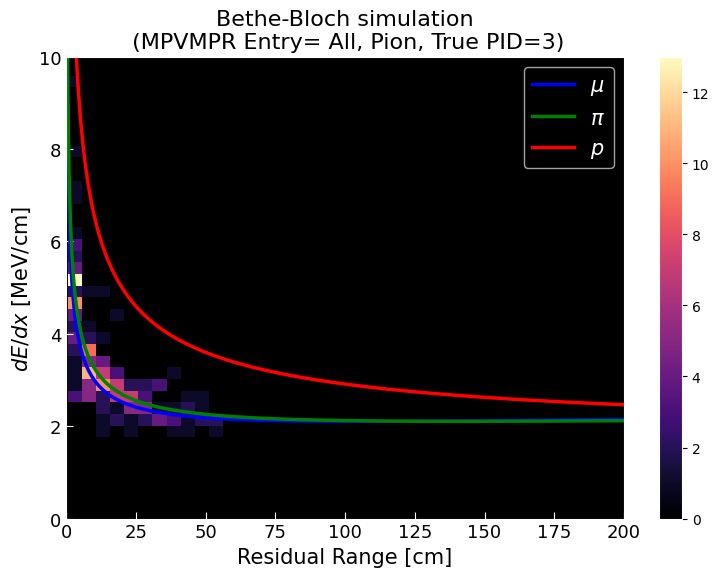

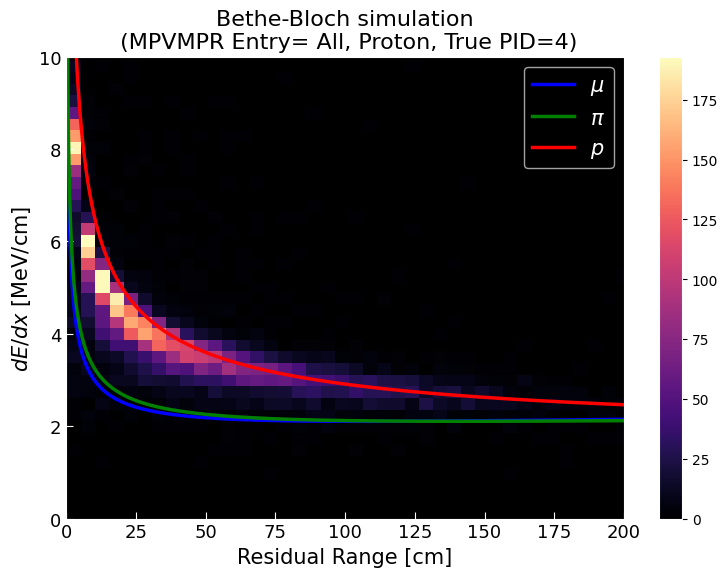

In [32]:
plt.style.use('dark_background')

for pid in pids:
    all_dedxs = filtered_dedxs_data[pid]
    all_rrs = filtered_rrs_data[pid]

    fig = plt.figure(figsize=(9, 6))
    fig.patch.set_facecolor('white')

    
    ax = sns.histplot(x=all_rrs, y=all_dedxs, bins=[int((max(all_rrs) - min(all_rrs)) / 5), 
                                                int((max(all_dedxs) - min(all_dedxs)) / 0.25)],
                                                cmap='magma', cbar=True)
    cbar = ax.collections[-1].colorbar
    cbar.ax.yaxis.set_tick_params(color='black')
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color='black')
    
    plt.grid(False)
    plt.tick_params(axis='both', which='both', direction='in', length=5, color='white', colors='black', labelsize=13)

    plt.plot(points, exp_dedxs[0], label=r'$\mu$', color='blue', linewidth=2.5)
    plt.plot(points, exp_dedxs[1], label=r'$\pi$', color='green', linewidth=2.5)
    plt.plot(points, exp_dedxs[2], label=r'$p$', color='red', linewidth=2.5)

    plt.xlabel('Residual Range [cm]', color='black', fontsize=15)
    plt.ylabel('$dE/dx$ [MeV/cm]', color='black', fontsize=15)
    plt.xlim(0, 200)
    plt.ylim(0, 10)

    particle_type = get_particle_type(pid)
    plt.title(f'Bethe-Bloch simulation\n (MPVMPR Entry= All, {particle_type}, True PID={pid})', color='black', fontsize=16)
    plt.legend(fontsize=15)
    
    title = f'Bethe_Bloch_2Dhist-dark_MPVMPR_PID={pid}'
    
    plt.show()

    fig.savefig(f'{output_dir}/{title.lower().replace(" ", "_")}.png', facecolor='white')



## V. Exercises

- Undesrtand and remove contribution from misreconstructed muons
  - Check event displays for events with wild outliers
  - Identify specific reconstruction issue
  - Introduce some selection to get rid of them
- Compute the mean/std for each residual range bin
- Repeat the above using `truth_particles` instead
  - Use `truth_particle.truth_depositions_MeV`
  - Compare the dE/dx vs. residual range to expectation
- Run on larger statistics
- Try it out with your favorite detector by changing the input file!
  
  